# ESOL Model 1: 
Graph-level regression model


In [11]:
import rdkit
from torch_geometric.datasets import MoleculeNet

data = MoleculeNet(root='data/ESOL', name='ESOL')

In [12]:
import torch
from torch.nn import Linear
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
embedding_size = 64

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.convs = torch.nn.ModuleList([
            GCNConv(
                data.num_features if i == 0 else embedding_size,
                embedding_size)
            for i in range(4)
        ])

        self.out = Linear(embedding_size, 1)
    def forward(self, x, edge_index, batch_index):
        hidden = x
        for conv in self.convs:
            hidden = conv(hidden, edge_index)
            hidden = F.relu(hidden)

        hidden = gap(hidden, batch_index)
        out = self.out(hidden)
        return out, hidden

model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (convs): ModuleList(
    (0): GCNConv(9, 64)
    (1-3): 3 x GCNConv(64, 64)
  )
  (out): Linear(in_features=64, out_features=1, bias=True)
)
Number of parameters:  13185


In [13]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

data_size = len(data)
NUM_GRAPHS_PER_BATCH = 64
loader = DataLoader(data[:int(data_size * 0.8)], 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(data[int(data_size * 0.8):], 
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

def train():
    for batch in loader:
      batch.to(device)  
      optimizer.zero_grad()
      pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch) 
      loss = loss_fn(pred, batch.y) 
      loss.backward()  
      optimizer.step()
    return loss, embedding

print("Starting training...")
losses = []
for epoch in range(2000):
    loss, h = train()
    losses.append(loss)
    if epoch % 100 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

Starting training...
Epoch 0 | Train Loss 15.059314727783203
Epoch 100 | Train Loss 0.7032454013824463
Epoch 200 | Train Loss 2.2013046741485596
Epoch 300 | Train Loss 1.5959382057189941
Epoch 400 | Train Loss 2.199847936630249
Epoch 500 | Train Loss 0.19474543631076813
Epoch 600 | Train Loss 0.43153873085975647
Epoch 700 | Train Loss 0.7788489460945129
Epoch 800 | Train Loss 1.191945195198059
Epoch 900 | Train Loss 0.37523961067199707
Epoch 1000 | Train Loss 0.8152596354484558
Epoch 1100 | Train Loss 2.543034315109253
Epoch 1200 | Train Loss 0.5954189300537109
Epoch 1300 | Train Loss 0.14442722499370575
Epoch 1400 | Train Loss 0.3836267292499542
Epoch 1500 | Train Loss 0.09793979674577713
Epoch 1600 | Train Loss 0.46839848160743713
Epoch 1700 | Train Loss 0.8267577290534973
Epoch 1800 | Train Loss 0.20499759912490845
Epoch 1900 | Train Loss 0.3381536304950714


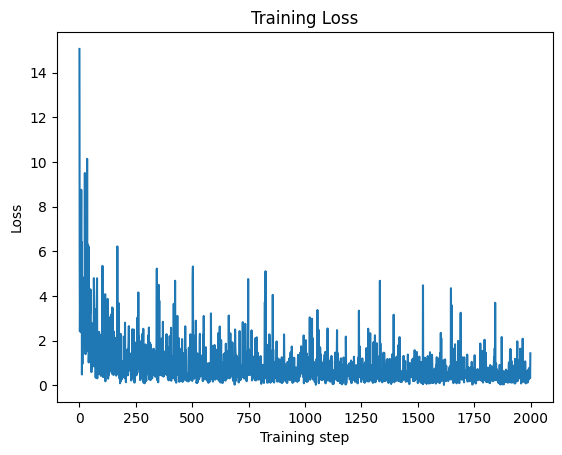

In [14]:
from master_functions import visualize_losses
visualize_losses(losses)

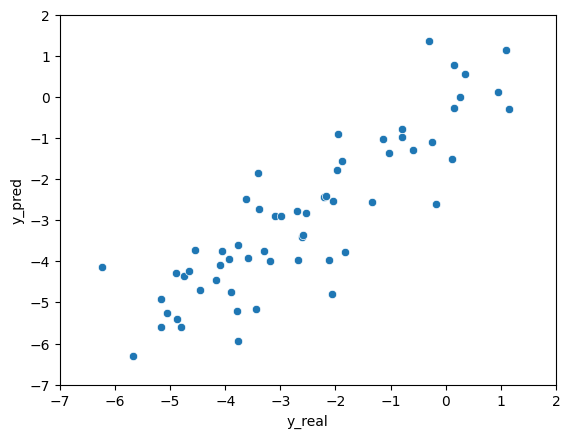

In [15]:
from master_functions import model_eval_one

model_eval_one(model, test_loader, device)

RMSE: 0.919
MAE: 0.701
R²: 0.794
Pearson correlation: 0.915 (p-value: 2.891e-90)


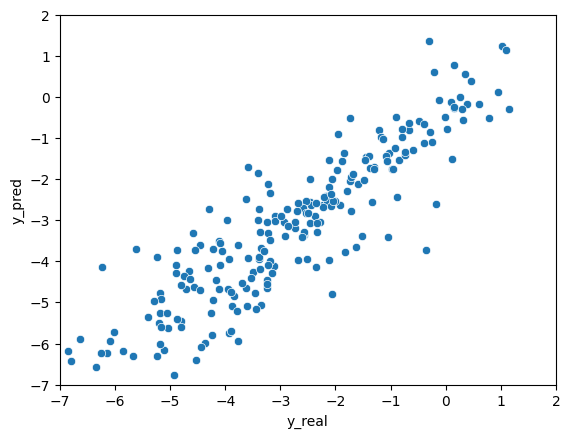

In [16]:
from master_functions import model_eval

model_eval(model, test_loader, device)

In [17]:
from master_functions import test

test()

hi
